<a href="https://colab.research.google.com/github/Peter-obi/JAX/blob/main/Calculating_derivatives.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Manual differentation

In [1]:
def f(x):
  return x**4 + 12*x + 1/x

In [2]:
def df(x):
  return 4*x**3 + 12 - 1/x**2

In [3]:
x = 11.0

In [4]:
print(f(x))

14773.09090909091


In [5]:
print(df(x))

5335.99173553719


##Symbolic differentiation

In [6]:
import sympy

In [7]:
x_sym = sympy.symbols('x') #define variable x
f_sym = f(x_sym) #creates a symbolic expression and pass th evariable
df_sym = sympy.diff(f_sym) #calculate symbolic derivative

In [8]:
print(f_sym)
print(df_sym)

x**4 + 12*x + 1/x
4*x**3 + 12 - 1/x**2


In [9]:
f = sympy.lambdify(x_sym, f_sym) #convert SymPy expressions into expressions that can be evaluated numerically
print(f(x))

14773.09090909091


In [10]:
df = sympy.lambdify(x_sym, df_sym)
print(df(x))

5335.99173553719


##Numerical differentiation

In [11]:
#finite differences -> estimate the derivative computing the slope of a nearby secant line through the points (x, f(x)) and (x + Δx, f(x + Δx))
x = 11.0
dx = 1e-6

In [12]:
df_x_numeric = (f(x + dx) - f(x)) / dx #rise/run
print(df_x_numeric)

5335.992456821259


##Automatic differentiation

In [13]:
import jax
df = jax.grad(f)
print(df(x))

5335.9917


In [14]:
import numpy as np
import matplotlib.pyplot as plt

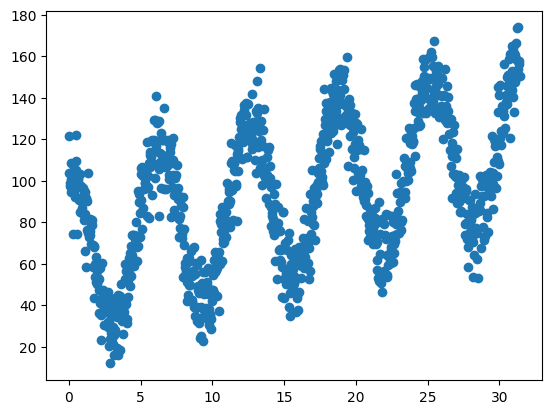

In [15]:
x = np.linspace(0, 10 * np.pi, 1000)
e = np.random.normal(scale=10.0, size=x.size ) #generate random gaussian noise
y = 65.0 + 1.8*x + 40*np.cos(x) + e #Generates the data consisting of bias, linear trend, sinusoidal wave, and noise
plt.scatter(x, y)

##Working with gradients in TensorFlow

In [16]:
import tensorflow as tf

In [17]:
xt = tf.constant(x, dtype=tf.float32) #convert training data into TensorFlow tensors
yt = tf.constant(y, dtype=tf.float32)

In [18]:
learning_rate = 1e-2

In [19]:
w = tf.Variable(1.0, trainable=True) #tensors with model weights marked with a flag to track gradients
b = tf.Variable(1.0, trainable=True)

In [20]:
def model(x):
  return w * x + b   #simple linear model

In [21]:
def loss_fn(prediction, y):
  return tf.reduce_mean(tf.square(prediction - y))

In [22]:
with tf.GradientTape() as tape:   #do computations inside the GradientTape context (tracks computation)
  prediction = model(xt)
  loss = loss_fn(prediction, yt)
dw, db = tape.gradient(loss, [w, b]) #extracts gradients from the gradient tape

In [23]:
w.assign_sub(learning_rate * dw) #make a single step of gradient update
b.assign_sub(learning_rate * db)

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=2.5332183837890625>

##Working with gradients in PyTorch

In [24]:
import torch

In [25]:
xt = torch.tensor(x) #convert training data into pytorch tensors
yt = torch.tensor(y)

In [26]:
learning_rate = 1e-2

In [27]:
w = torch.tensor(1.0, requires_grad=True) #tensors with model weights marked with a flag to track gradients
b = torch.tensor(1.0, requires_grad=True)

In [28]:
def model(x):
  return w * x + b

In [29]:
def loss_fn(prediction, y):
  return ((prediction - y)**2).mean()

In [30]:
prediction = model(xt)
loss = loss_fn(prediction, yt)
loss.backward() #calculates gradients

In [31]:
with torch.no_grad():              #uses context manager to disable gradient calculations (we do not want parameter updates to affect gradients)
  w -= w.grad * learning_rate      #makes a single step of gradient update
  b -= b.grad * learning_rate
  w.grad.zero_()                   #sets the gradients to zero before the next gradient computation
  b.grad.zero_()

##Working with gradients in JAX

In [32]:
import jax.numpy as jnp

In [33]:
xt = jnp.array(x)
yt = jnp.array(y)

In [34]:
learning_rate = 1e-2

In [35]:
model_parameters = jnp.array([1., 1.]) #tensors with model weights, doesnt need a special tag

In [36]:
def model(theta, x):
  w, b = theta
  return w * x + b

In [37]:
def loss_fn(model_parameters, x, y):     #MSE loss function
  prediction = model(model_parameters, x)
  return jnp.mean((prediction-y)**2)

In [38]:
grads_fn = jax.grad(loss_fn) #creates a function for creating gradients
grads = grads_fn(model_parameters, xt, yt) #calculates gradients for the first parameter ie model_parameters
model_parameters -= learning_rate * grads #makes a single step of gradient update

##Differentiate with respect to positions other than the first

In [39]:
def dist(order, x, y): #additional parameter -> calculate Minkowski distance
  return jnp.power(jnp.sum(jnp.abs(x-y)**order), 1.0/order)

In [40]:
dist_d_x = jax.grad(dist, argnums=1) #differentiate with respect to 2nd parameter, x
dist_d_x(1, jnp.array([1.0, 1.0, 1.0]), jnp.array([2.0, 2.0, 2.0]))

Array([-1., -1., -1.], dtype=float32)

In [41]:
dist_d_xy = jax.grad(dist, argnums=(1,2)) #differentiate with respect to multiple parameters
dist_d_xy(1, jnp.array([1.0, 1.0, 1.0]), jnp.array([2.0, 2.0, 2.0]))

(Array([-1., -1., -1.], dtype=float32), Array([1., 1., 1.], dtype=float32))

##Differentiate dictionary

In [44]:
model_parameters = {
    'w': jnp.array([1.]),
    'b': jnp.array([1.])
}

def model(param_dict, x):
  w, b = param_dict['w'], param_dict['b'] #works with dict
  return w * x + b

def loss_fn(model_parameters, x, y):
  prediction = model(model_parameters, x)
  return jnp.mean((prediction-y)**2)

In [45]:
grads_fn = jax.grad(loss_fn)
grads = grads_fn(model_parameters, xt, yt)
grads

{'b': Array([-153.32184], dtype=float32),
 'w': Array([-2540.1191], dtype=float32)}

##Return auxillary data from a function

In [46]:
model_parameters = jnp.array([1., 1.])

In [51]:
def model(theta, x):
  w, b = theta
  return w * x + b

def loss_fn(model_parameters, x, y):
  prediction = model(model_parameters, x)
  return jnp.mean((prediction-y)**2), prediction #returns prediction results too

In [49]:
grads_fn = jax.grad(loss_fn, has_aux=True) #has aux->function now returns a pair(out, aux)
grads, preds = grads_fn(model_parameters, xt, yt) #returns both gradients and auxillary data, predictions.
model_parameters -= learning_rate * grads

In [54]:
grads_fn = jax.value_and_grad(loss_fn, has_aux=True) #get values and gradients
(loss, preds), grads = grads_fn(model_parameters, xt, yt) #returns both gradients and auxillary data, and loss_values
model_parameters -= learning_rate * grads

##Stop gradient flow

In [55]:
def f(x, y):
  return x**2 + jax.lax.stop_gradient(y**2) #uses stop_gradient() to prevent gradient calculation for y

jax.grad(f, argnums=(0,1)) (1.0, 1.0) #calculates gradient at a particular point

(Array(2., dtype=float32, weak_type=True),
 Array(0., dtype=float32, weak_type=True))

##Higher-order derivatives

In [56]:
def f(x):
  return x**4 + 12*x + 1/x

In [57]:
f_d1 = jax.grad(f)#first derivative
f_d2 = jax.grad(f_d1)#second derivative
f_d3 = jax.grad(f_d2)#third derivative

In [58]:
x = 11.0

In [60]:
print(f_d1(x))
print(f_d2(x))
print(f_d3(x))

5335.9917
1452.0015
263.9996


In [62]:
f_d3 = jax.grad(jax.grad(jax.grad(f)))
print(f_d3(x))

263.9996


In [63]:
def f(x):
  return x**3 + 12*x + 7*x*jnp.sin(x)

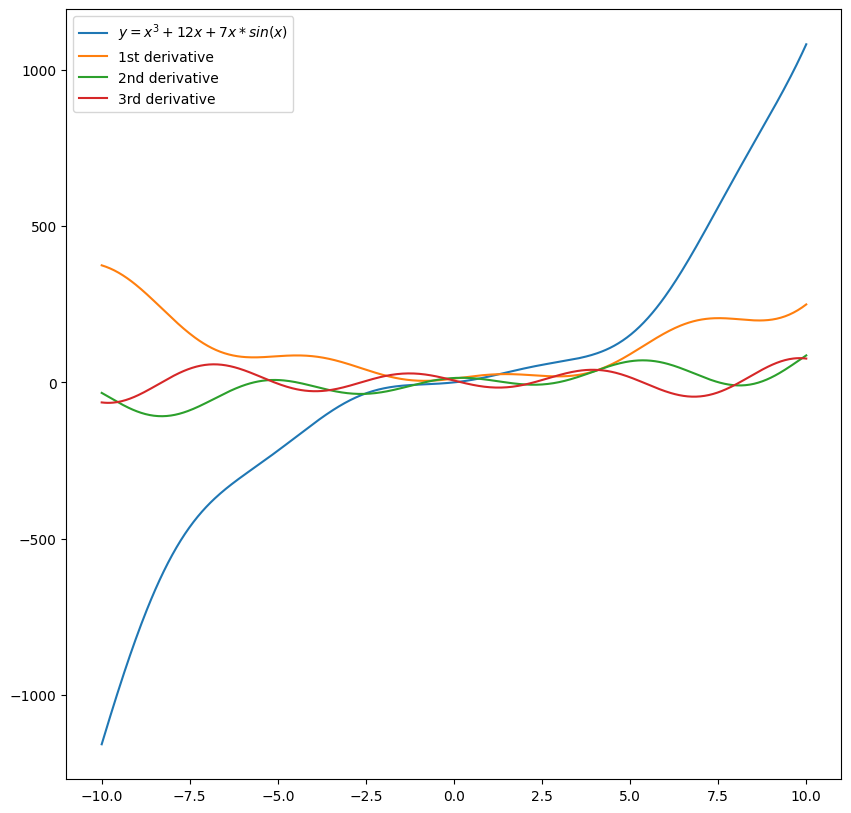

In [71]:
x = np.linspace(-10, 10, num=500)

fig, ax = plt.subplots(figsize=(10,10))
ax.plot(x, f(x), label = r"$y = x^3 + 12x + 7x*sin(x)$")

df = f
for d in range(3):
  df = jax.grad(df)
  ax.plot(x, jax.vmap(df)(x),
          label = f"{['1st', '2nd', '3rd'] [d]} derivative")
  ax.legend()